## Context

Analyzing trends in text corpora over time can provide valuable insights into public beliefs, interests, and sentiment surrounding a topic. This [dataset](https://www.kaggle.com/datasets/saurabhshahane/public-perception-of-ai) focuses on views about **artificial intelligence (AI)** in *The New York Times* over a span of 30 years. Historical trends show fluctuating interest in AI since the field's establishment in 1956.

## Importing Necessary Libraries

We start by importing essential libraries for data manipulation, visualization, and analysis:

In [161]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# Load the dataset
file_path = 'robot-ai-all-public.csv'
df = pd.read_csv(file_path)

# Clean Data
print(df.duplicated().any())

# drop any duplicate values if any
print(f"Before {df.shape}")
df = df.drop_duplicates()
print(df.duplicated().any()) # should print False
print(f"After {df.shape}")

# drop rows with all null values
df = df.dropna(how='all', axis=0)
df.shape

True
Before (17073, 27)
False
After (17068, 27)


(17068, 27)

In [162]:
# Dropping unnecessary columns
columns_to_drop = ['Article ID', 'Paragraph number', 'Paragraph', 'WorkTimeInSeconds', 'Other (negative)', 'Other (positive)']
df = df.drop(columns=columns_to_drop, errors='ignore')
# df.head()

## Processing Article Dates and Extracting Years

The `Article Date` column is cleaned and parsed to handle invalid dates and extract the respective years. Invalid dates, such as floating-point values, are replaced with a placeholder date (`0001-01-01`) and assigned a default year of `1`. Valid dates are split and parsed to extract the year accurately.

The processing results in two new columns:
- `Article Date`: Contains the cleaned date information.
- `Article Year`: Contains the extracted years from valid dates, ready for analysis.

This ensures that date inconsistencies are managed, and valid yearly trends can be analyzed downstream.

In [163]:
dates = []
years = []

for i in df.iterrows():
    article_date = list(i)[1][0]  # example date: "1996-10-06 00:00:00 UTC"

    # there are some empty dates stored as "nan", floating-point values
    # we will store the empty/invalid dates as 0001-01-01
    if isinstance(article_date, float):
        new_date = datetime.date(1, 1, 1)
        new_year = 1
    else:
        new_date = article_date.split(" ")
        new_date = new_date[0].split("-")
        
        if len(new_date) == 3:
            new_date = datetime.date(int(new_date[0]), int(new_date[1]), int(new_date[2]))
            new_year = new_date.year
        else:
            # Dates without length of 3 will be considered invalid
            new_date = datetime.date(1, 1, 1)
            new_year = 1
    
    dates.append(new_date)
    years.append(new_year)

df["Article Date"] = dates
df["Article Year"] = years

In [164]:
# Run this code cell to see what the current DataFrame looks like
df.head(3)

,Article Date,NYT section,Title,AI Mood,AI Relevance,Fiction,Controling AI (negative),Cyborg (negative),Ethics (negative),Military (negative),...,Work (negative),Cyborg (positive),Decisions (positive),Education (positive),Entertain (positive),Healthcare (positive),Singularity (positive),Transportation (positive),Work (positive),Article Year
0,1996-10-06,New York and Region,LONG ISLAND JOURNAL,4,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1996
1,1996-10-06,New York and Region,LONG ISLAND JOURNAL,4,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1996
2,1996-10-06,New York and Region,LONG ISLAND JOURNAL,5,5,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1996


**Data Cleaning: Filtering Invalid Dates**

The following code snippet filters out rows with invalid dates -- represented by the placeholder year 1 that we set in the previous cells

In [165]:
new_df = []

for i in df.iterrows():
    date = list(i)[1]["Article Year"]

    # The year is only 1 if there was no date
    if date != 1:
        new_df.append(list(i)[1])

df_cleaned_dates = pd.DataFrame(new_df)

# Uncomment to check if any rows with invalid dates are left
# invalid_rows = df_cleaned_dates[df_cleaned_dates["Article Date"] == datetime.date(1, 1, 1)]
# invalid_rows.count().sum()
    

## Visualizations

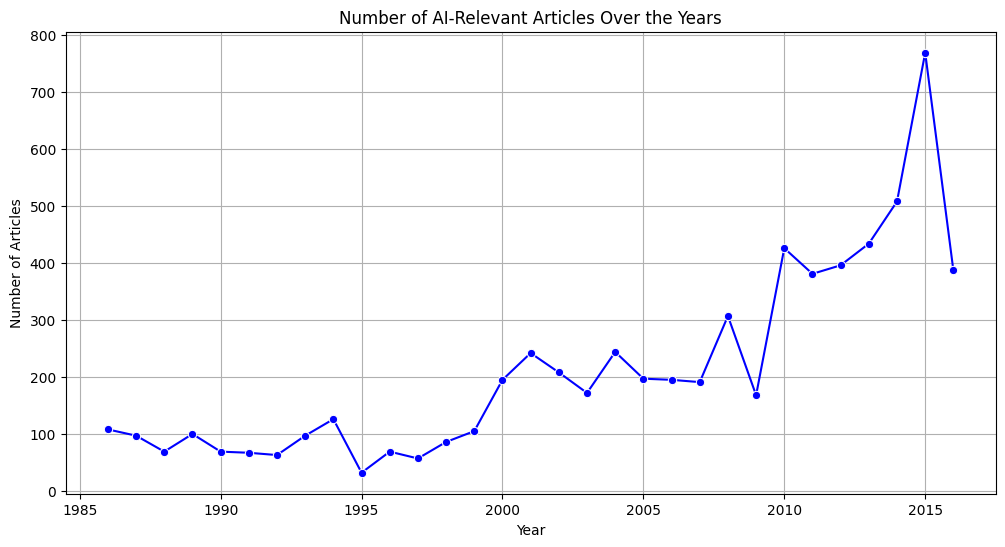

In [166]:
# Filter for AI-relevant articles (AI Relevance of 3 or 4 or 5)
ai_relevant_articles = df_cleaned_dates[df_cleaned_dates['AI Relevance'].isin([3, 4, 5])]

# Count the number of AI-relevant articles for each year
articles_per_year = ai_relevant_articles['Article Year'].value_counts().sort_index().reset_index()
articles_per_year.columns = ['Year', 'Number of Articles']

# Plot a line graph
plt.figure(figsize=(12, 6))
sns.lineplot(data=articles_per_year, x='Year', y='Number of Articles', marker='o', color='blue')
plt.title('Number of AI-Relevant Articles Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

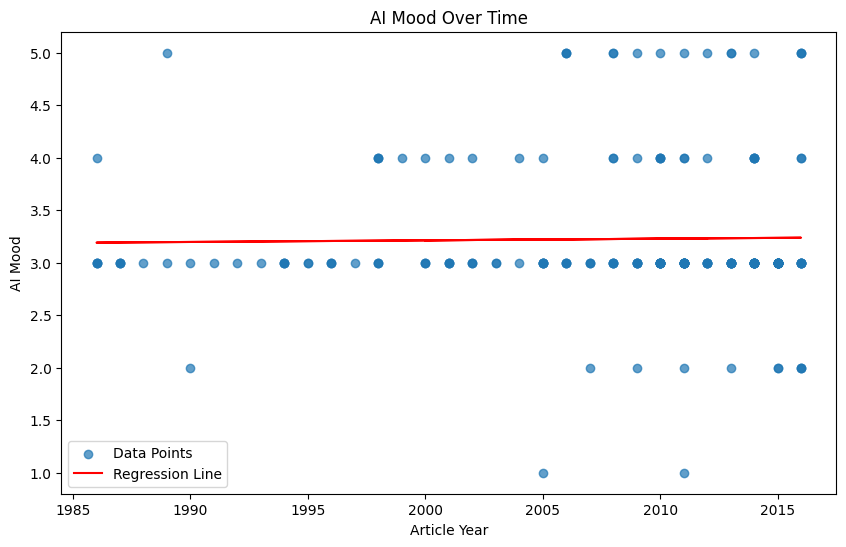

In [167]:
# Ensure the columns are numeric and handle missing values
df_cleaned_dates['Article Year'] = pd.to_numeric(df['Article Year'], errors='coerce')
df_cleaned_dates['AI Mood'] = pd.to_numeric(df_cleaned_dates['AI Mood'], errors='coerce')
df_cleaned_dates = df_cleaned_dates.dropna(subset=['Article Year', 'AI Mood'])  # Drop rows with missing values

# Sample the dataset for better visualization
sampled_df = df_cleaned_dates.sample(200, random_state=1)

# Perform a linear regression fit
pfit = np.polyfit(sampled_df['Article Year'], sampled_df['AI Mood'], 1)
func = np.poly1d(pfit)

# Add the fit line to the DataFrame
sampled_df['Fit'] = func(sampled_df['Article Year'])

# Create scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(sampled_df['Article Year'], sampled_df['AI Mood'], alpha=0.7, label='Data Points')
plt.plot(sampled_df['Article Year'], sampled_df['Fit'], color='red', label='Regression Line')
plt.title('AI Mood Over Time')
plt.xlabel('Article Year')
plt.ylabel('AI Mood')
plt.legend()
plt.show()


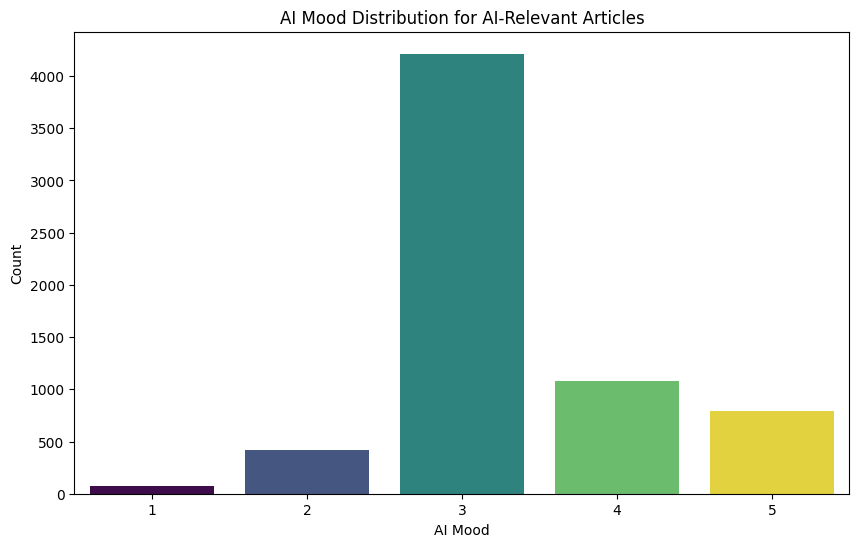

AI Mood Counts for AI-Relevant Articles:
AI Mood
1      72
2     414
3    4214
4    1076
5     789
Name: count, dtype: int64


In [168]:
# Summarize the distribution of AI Mood
ai_mood_counts = ai_relevant_articles['AI Mood'].value_counts().sort_index() #AI relevant articles of 3-5

# Create a bar chart to visualize AI Mood distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=ai_mood_counts.index, y=ai_mood_counts.values, palette="viridis", hue=ai_mood_counts.index, legend=False)
plt.title('AI Mood Distribution for AI-Relevant Articles')
plt.xlabel('AI Mood')
plt.ylabel('Count')
plt.show()

# Print detailed counts for each AI Mood value
print("AI Mood Counts for AI-Relevant Articles:")
print(ai_mood_counts)

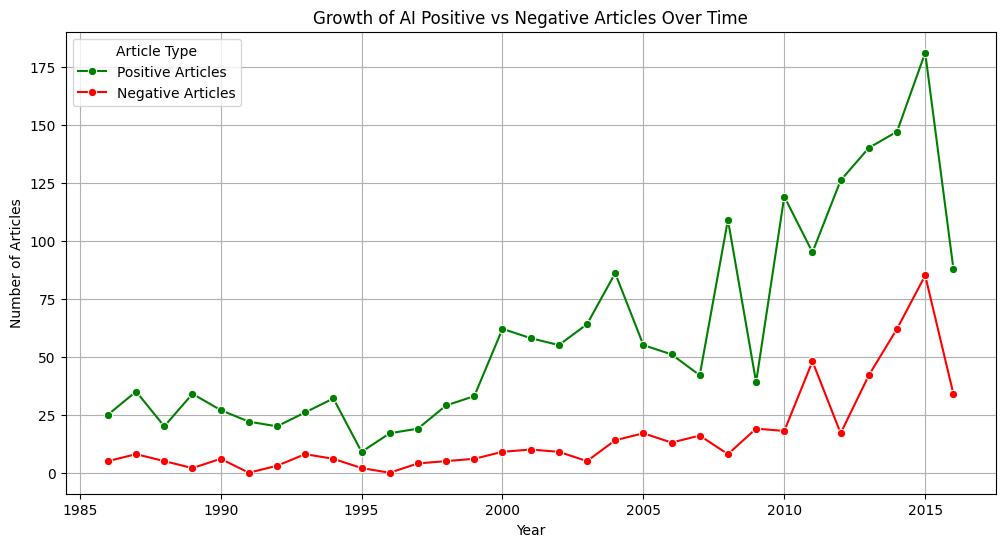

Comparison of Positive and Negative Articles Over Time:
    Year  Positive Articles  Negative Articles
0   1986                 25                5.0
1   1987                 35                8.0
2   1988                 20                5.0
3   1989                 34                2.0
4   1990                 27                6.0
5   1991                 22                0.0
6   1992                 20                3.0
7   1993                 26                8.0
8   1994                 32                6.0
9   1995                  9                2.0
10  1996                 17                0.0
11  1997                 19                4.0
12  1998                 29                5.0
13  1999                 33                6.0
14  2000                 62                9.0
15  2001                 58               10.0
16  2002                 55                9.0
17  2003                 64                5.0
18  2004                 86               14.0
19  

In [169]:
# Separate articles into positive and negative groups based on AI Mood
positive_articles = ai_relevant_articles[ai_relevant_articles['AI Mood'].isin([4, 5])]
negative_articles = ai_relevant_articles[ai_relevant_articles['AI Mood'].isin([1, 2])]

# Count the number of positive and negative articles for each year
positive_counts = positive_articles['Article Year'].value_counts().sort_index().reset_index()
negative_counts = negative_articles['Article Year'].value_counts().sort_index().reset_index()

# Rename columns for clarity
positive_counts.columns = ['Year', 'Positive Articles']
negative_counts.columns = ['Year', 'Negative Articles']

# Merge positive and negative counts on Year
comparison = pd.merge(positive_counts, negative_counts, on='Year', how='outer').fillna(0)

# Sort by Year for plotting
comparison = comparison.sort_values(by='Year')

# Plot the comparison graph
plt.figure(figsize=(12, 6))
sns.lineplot(data=comparison, x='Year', y='Positive Articles', marker='o', label='Positive Articles', color='green')
sns.lineplot(data=comparison, x='Year', y='Negative Articles', marker='o', label='Negative Articles', color='red')
plt.title('Growth of AI Positive vs Negative Articles Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.legend(title='Article Type')
plt.grid(True)
plt.show()

# Print the comparison dataframe for reference
print("Comparison of Positive and Negative Articles Over Time:")
print(comparison)

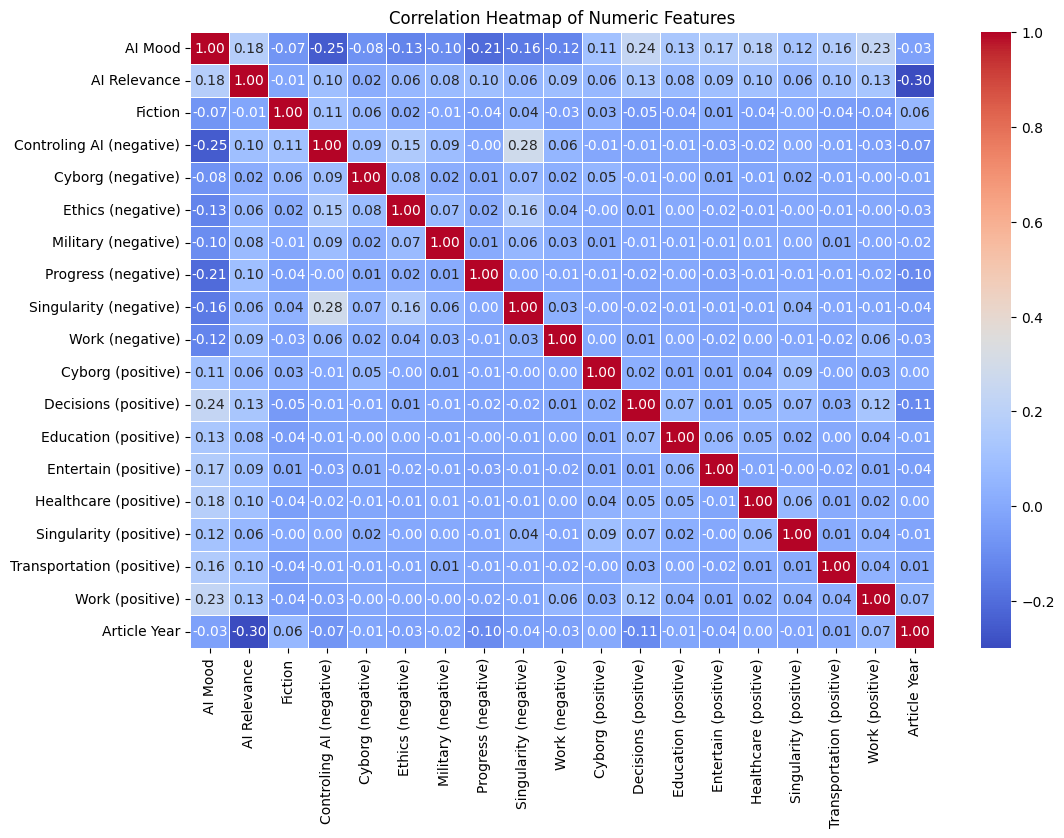

In [170]:
# 4. Correlation Heatmap

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()